# 🧬 Mergekit Evolutionary Algorithm

This notebook demonstrates how to run the **mergekit evolutionary algorithm** to automatically optimize model merging parameters using genetic algorithms.

## 🎯 Objective
We'll merge two Qwen models using the `dare_ties` method and optimize the merging parameters using CMA-ES evolutionary algorithm:
- **Base Model**: `Qwen/Qwen2.5-Coder-1.5B`
- **Target Model**: `Qwen/Qwen2.5-1.5B-Instruct`
- **Evaluation Tasks**: `boolq` and `lambada_openai`

## 🔧 Key Features
- ✅ fix source code for lm_eval API compatibility
- ✅ Fixed chat template error by setting `apply_chat_template: false`
- ✅ Fixed multiturn formatting by setting `fewshot_as_multiturn: false`

## ⚠️ Requirements
- Google Colab with GPU runtime (T4, V100, or A100)
- ~8-12 GB VRAM for model evaluation
- ~30-60 minutes runtime depending on evolution parameters

---

Let's get started! 🚀

## 📋 Install and Setup Dependencies

First, let's check our GPU resources and install all required dependencies.

In [1]:
# Check GPU availability and system info
import torch
import os
import subprocess

print("🔍 System Information:")
print(f"Python version: {subprocess.check_output(['python', '--version']).decode().strip()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("❌ No GPU available! Please enable GPU runtime in Colab.")
    print("Runtime > Change runtime type > Hardware accelerator > GPU")

# Set environment variables for optimal performance
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['TRANSFORMERS_CACHE'] = '/content/transformers_cache'

🔍 System Information:
Python version: Python 3.11.5
PyTorch version: 2.8.0
CUDA available: False
❌ No GPU available! Please enable GPU runtime in Colab.
Runtime > Change runtime type > Hardware accelerator > GPU


In [2]:
print("📦 Installing Claude Code CLI using npm...")
# The '-g' flag installs it globally within the Colab environment
!npm install -g @anthropic-ai/claude-code
print("\n✅ Installation complete!")

# --- IMPORTANT ---
# The first time you run '!claude', you will be asked to log in.
# A URL will be displayed. You need to copy this URL, paste it into a new
# browser tab, and complete the authentication.
# After that, you won't need to do it again in this session.

📦 Installing Claude Code CLI using npm...
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼
added 3 packages in 3s
⠼
⠼2 packages are looking for funding
⠼  run `npm fund` for details
⠼
✅ Installation complete!


In [ ]:
# Install required packages
!pip install --quiet --upgrade pip

# !pip install --quiet lm-eval[api]==0.4.4

print("✅ Core packages installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 62.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'rouge-score' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'rouge-score'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'sqlitedict' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or addi

## 🔧 Clone and Setup Modified Merge-Kit

We'll clone the official mergekit repository and apply the necessary fix for the lm_eval API.

In [4]:
# Clone mergekit repository
import os
import shutil

# Remove existing mergekit if present
if os.path.exists('/content/mergekit'):
    shutil.rmtree('/content/mergekit')

print("📥 Cloning mergekit repository...")
!git clone https://github.com/arcee-ai/mergekit.git /content/mergekit

# Change to mergekit directory
os.chdir('/content/mergekit')

# Install mergekit with evolve features
print("🔨 Installing mergekit with evolve features...")
!pip install --quiet -e .[evolve]

print("✅ Mergekit installed with evolve features!")

📥 Cloning mergekit repository...
Cloning into '/content/mergekit'...
remote: Enumerating objects: 3273, done.
remote: Counting objects: 100% (1333/1333), done.
remote: Compressing objects: 100% (431/431), done.
remote: Total 3273 (delta 1146), reused 902 (delta 902), pack-reused 1940 (from 5)
Receiving objects: 100% (3273/3273), 1.13 MiB | 2.40 MiB/s, done.
Resolving deltas: 100% (2236/2236), done.
🔨 Installing mergekit with evolve features...
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mergekit (pyproject.toml) ... done
✅ Mergekit installed with evolve features!


In [5]:
# 🔥 CRITICAL FIX: Apply lm_eval API fix
# This fixes the AttributeError: module 'lm_eval' has no attribute 'evaluator'

helpers_file = '/content/mergekit/mergekit/evo/helpers.py'

print("🔧 Applying critical lm_eval fix...")

# Read the file
with open(helpers_file, 'r') as f:
    content = f.read()

# Apply the fix: change lm_eval.evaluator.simple_evaluate to lm_eval.simple_evaluate
if 'lm_eval.evaluator.simple_evaluate' in content:
    content = content.replace('lm_eval.evaluator.simple_evaluate', 'lm_eval.simple_evaluate')

    # Write back the fixed content
    with open(helpers_file, 'w') as f:
        f.write(content)

    print("✅ lm_eval fix applied successfully!")
    print("   Changed: lm_eval.evaluator.simple_evaluate → lm_eval.simple_evaluate")
else:
    print("ℹ️  Fix may already be applied or file structure changed")

# Verify the fix
with open(helpers_file, 'r') as f:
    lines = f.readlines()

for i, line in enumerate(lines[30:40], 31):  # Check around line 33 where the fix should be
    if 'simple_evaluate' in line:
        print(f"Line {i}: {line.strip()}")

print("🔍 Fix verification complete!")

🔧 Applying critical lm_eval fix...
✅ lm_eval fix applied successfully!
   Changed: lm_eval.evaluator.simple_evaluate → lm_eval.simple_evaluate
Line 33: results = lm_eval.simple_evaluate(
🔍 Fix verification complete!


## ⚙️ Upload Configuration File

Now let's create and configure our evolution parameters.

In [6]:
# Create the working evolution config that fixes the chat template issue
config_yaml = """genome:
  base_model: Qwen/Qwen2.5-Coder-1.5B
  models:
    - Qwen/Qwen2.5-1.5B-Instruct
  merge_method: dare_ties
  normalize: false
  allow_negative_weights: true
  layer_granularity: 7
  dtype: float16
apply_chat_template: false  # KEY FIX: Disable chat template usage
fewshot_as_multiturn: false # KEY FIX: Disable multiturn fewshot
tasks:
  - name: "boolq"
    limit: 5  # Even smaller for faster testing
    metric: "acc,none"
    weight: 1.0
  """

# Save configuration file
config_path = '/content/evolve_config.yml'
with open(config_path, 'w') as f:
    f.write(config_yaml)

print("📝 Evolution configuration created:")
print(config_yaml)
print(f"✅ Configuration saved to: {config_path}")

# Validate the configuration
import yaml
from mergekit.evo.config import EvolMergeConfiguration

try:
    with open(config_path, 'r') as f:
        config_data = yaml.safe_load(f)

    config = EvolMergeConfiguration.model_validate(config_data)
    print("✅ Configuration validation passed!")
    print(f"   Base model: {config.genome.base_model}")
    print(f"   Target models: {[str(m.model.path) for m in config.genome.models]}")
    print(f"   Merge method: {config.genome.merge_method}")
    print(f"   Tasks: {[task.name for task in config.tasks]}")
    print(f"   Layer granularity: {config.genome.layer_granularity}")

except Exception as e:
    print(f"❌ Configuration validation failed: {e}")
    raise

📝 Evolution configuration created:
genome:
  base_model: Qwen/Qwen2.5-Coder-1.5B
  models:
    - Qwen/Qwen2.5-1.5B-Instruct
  merge_method: dare_ties
  normalize: false
  allow_negative_weights: true
  layer_granularity: 7
  dtype: float16
apply_chat_template: false  # KEY FIX: Disable chat template usage
fewshot_as_multiturn: false # KEY FIX: Disable multiturn fewshot
tasks:
  - name: "boolq"
    limit: 5  # Even smaller for faster testing
    metric: "acc,none"
    weight: 1.0
  
✅ Configuration saved to: /content/evolve_config.yml


/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


✅ Configuration validation passed!
   Base model: Qwen/Qwen2.5-Coder-1.5B
   Target models: ['Qwen/Qwen2.5-1.5B-Instruct']
   Merge method: dare_ties
   Tasks: ['boolq']
   Layer granularity: 7


## 🚀 Run Evolution Algorithm

Time to run the evolutionary algorithm! This will merge models, evaluate them, and evolve better configurations.

In [7]:
%cd /content

/content


In [8]:
!ls

evolve_config.yml  mergekit  sample_data


In [12]:
!python -m mergekit.scripts.evolve evolve_config.yml  --storage-path evolution_storage --max-fevals 100 --num-gpus 1  --no-vllm --allow-crimes --i-understand-the-depths-of-the-evils-i-am-unleashing  --no-wandb --save-final-model  --timeout 7200

Streaming output truncated to the last 5000 lines.
Running loglikelihood requests: 100%|██████████| 6540/6540 [02:12<00:00, 49.21it/s]
(OnDiskMergeEvaluator pid=29529) WARNING:lm-eval:Failed to get model SHA for evolution_storage/merged/mergedkai2c2f5 at revision main. Error: Repo id must be in the form 'repo_name' or 'namespace/repo_name': 'evolution_storage/merged/mergedkai2c2f5'. Use `repo_type` argument if needed.
(OnDiskMergeEvaluator pid=29529) fatal: not a git repository (or any of the parent directories): .git
(OnDiskMergeEvaluator pid=29529) WARNING:lm-eval:[Task: boolq] metric acc is defined, but aggregation is not. using default aggregation=mean
(OnDiskMergeEvaluator pid=29529) WARNING:lm-eval:[Task: boolq] metric acc is defined, but higher_is_better is not. using default higher_is_better=True
Running loglikelihood requests: 100%|██████████| 6540/6540 [02:12<00:00, 49.44it/s]
(OnDiskMergeEvaluator pid=29529) WARNING:lm-eval:Failed to get model SHA for evolution_storage/merge

## 📊 Monitor Progress and Results

Let's analyze the evolution results and track the performance improvements.

In [15]:
# Parse and analyze evolution results
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Define paths
outcmaes_path = Path('/content/outcmaes')
storage_path = Path('/content/evolution_storage')

print("🔍 Analyzing evolutionary algorithm results...")

# Parse fitness evolution data
def parse_fitness_data(file_path):
    """Parse CMA-ES fitness evolution data"""
    with open(file_path, 'r') as f:
        lines = f.readlines()

    data = []
    for line in lines[1:]:  # Skip header
        if line.strip() and not line.startswith('%'):
            parts = line.strip().split()
            if len(parts) >= 8:  # Ensure we have enough columns
                data.append({
                    'iteration': int(parts[0]),
                    'evaluation': int(parts[1]),
                    'sigma': float(parts[2]),
                    'axis_ratio': float(parts[3]),
                    'best_ever': float(parts[4]),
                    'best': float(parts[5]),
                    'median': float(parts[6]),
                    'worst': float(parts[7]),
                    'iqr': float(parts[8]) if len(parts) > 8 else 0.0
                })
    return pd.DataFrame(data)

# Parse parameter evolution data
def parse_parameter_data(file_path):
    """Parse CMA-ES parameter evolution data"""
    with open(file_path, 'r') as f:
        lines = f.readlines()

    data = []
    for line in lines[1:]:  # Skip header
        if line.strip() and not line.startswith('%'):
            parts = line.strip().split()
            if len(parts) >= 8:  # We expect at least 8 parameters based on best_config.yaml
                row = {
                    'iteration': int(parts[0]),
                    'evaluation': int(parts[1])
                }
                # Add parameter values (skip first 5 columns which are metadata)
                for i, val in enumerate(parts[5:], 1):
                    row[f'param_{i}'] = float(val)
                data.append(row)
    return pd.DataFrame(data)

# Load the data
fitness_df = parse_fitness_data(outcmaes_path / 'fit.dat')
param_df = parse_parameter_data(outcmaes_path / 'xmean.dat')

print(f"✅ Loaded evolution data:")
print(f"   - Fitness data: {len(fitness_df)} generations")
print(f"   - Parameter data: {len(param_df)} generations")
print(f"   - Total evaluations: {fitness_df['evaluation'].max() if not fitness_df.empty else 0}")

# Display basic statistics
if not fitness_df.empty:
    print(f"\n📈 Evolution Progress:")
    if len(fitness_df) > 1:
        print(f"   - Initial best fitness: {fitness_df['best'].iloc[0]:.4f}")
        print(f"   - Final best fitness: {fitness_df['best'].iloc[-1]:.4f}")
        print(f"   - Best ever fitness: {fitness_df['best_ever'].min():.4f}")
        print(f"   - Improvement: {fitness_df['best'].iloc[-1] - fitness_df['best'].iloc[0]:.4f}")
        print(f"   - Improvement %: {((fitness_df['best'].iloc[-1] - fitness_df['best'].iloc[0]) / abs(fitness_df['best'].iloc[0]) * 100):.2f}%")
    else:
        print(f"   - Single generation result (quick evolution run)")
        print(f"   - Best fitness achieved: {fitness_df['best'].iloc[0]:.4f}")
        print(f"   - Best ever fitness: {fitness_df['best_ever'].iloc[0]:.4f}")
        print(f"   - Median population fitness: {fitness_df['median'].iloc[0]:.4f}")

# Load best configuration
try:
    with open(storage_path / 'best_config.yaml', 'r') as f:
        best_config = yaml.safe_load(f)
    print(f"\n🏆 Best Configuration Found:")
    print(f"   - Merge method: {best_config.get('merge_method', 'N/A')}")
    print(f"   - Data type: {best_config.get('dtype', 'N/A')}")
    print(f"   - Layer slices: {len(best_config.get('slices', []))}")

    # Analyze layer-specific parameters
    if 'slices' in best_config:
        for i, slice_config in enumerate(best_config['slices']):
            if 'sources' in slice_config:
                for source in slice_config['sources']:
                    if 'parameters' in source:
                        layer_range = source.get('layer_range', [])
                        weight = source['parameters'].get('weight', 1.0)
                        density = source['parameters'].get('density', 1.0)
                        print(f"   - Layers {layer_range}: weight={weight:.4f}, density={density:.4f}")
except Exception as e:
    print(f"⚠️  Could not load best config: {e}")

# Show data preview
print(f"\n🔍 Data Preview:")
if not fitness_df.empty:
    print("Fitness Data:")
    display(fitness_df.head())
else:
    print("❌ No fitness data available")

if not param_df.empty:
    print("\nParameter Data:")
    display(param_df.head())
else:
    print("❌ No parameter data available")


🔍 Analyzing evolutionary algorithm results...
✅ Loaded evolution data:
   - Fitness data: 3 generations
   - Parameter data: 3 generations
   - Total evaluations: 30

📈 Evolution Progress:
   - Initial best fitness: -0.7294
   - Final best fitness: -0.7550
   - Best ever fitness: -0.7550
   - Improvement: -0.0257
   - Improvement %: -3.52%

🏆 Best Configuration Found:
   - Merge method: dare_ties
   - Data type: bfloat16
   - Layer slices: 4
   - Layers [0, 7]: weight=1.1047, density=1.0000
   - Layers [7, 14]: weight=0.8545, density=1.0000
   - Layers [14, 21]: weight=0.7855, density=0.9581
   - Layers [21, 28]: weight=1.1819, density=0.9754

🔍 Data Preview:
Fitness Data:


,iteration,evaluation,sigma,axis_ratio,best_ever,best,median,worst,iqr
0,1,10,0.150285,1.000044,-0.729358,-0.729358,-0.517125,-0.416514,0.195413
1,2,20,0.135290,1.189972,-0.729358,-0.685933,-0.551070,-0.448624,0.090826
2,3,30,0.128850,1.337226,-0.755046,-0.755046,-0.620489,-0.418349,0.137003



Parameter Data:


,iteration,evaluation,param_1,param_2,param_3,param_4,param_5,param_6,param_7,param_8
0,1,10,0.963731,1.001252,0.895133,1.081841,0.917919,0.952425,1.115703,1.011006
1,2,20,0.922033,0.917405,0.886962,1.105234,0.946926,0.910919,1.107291,1.065786
2,3,30,1.024400,1.132970,0.954603,1.092786,0.868083,0.967155,1.142658,1.061378


📊 Creating visualizations for multi-generation data...


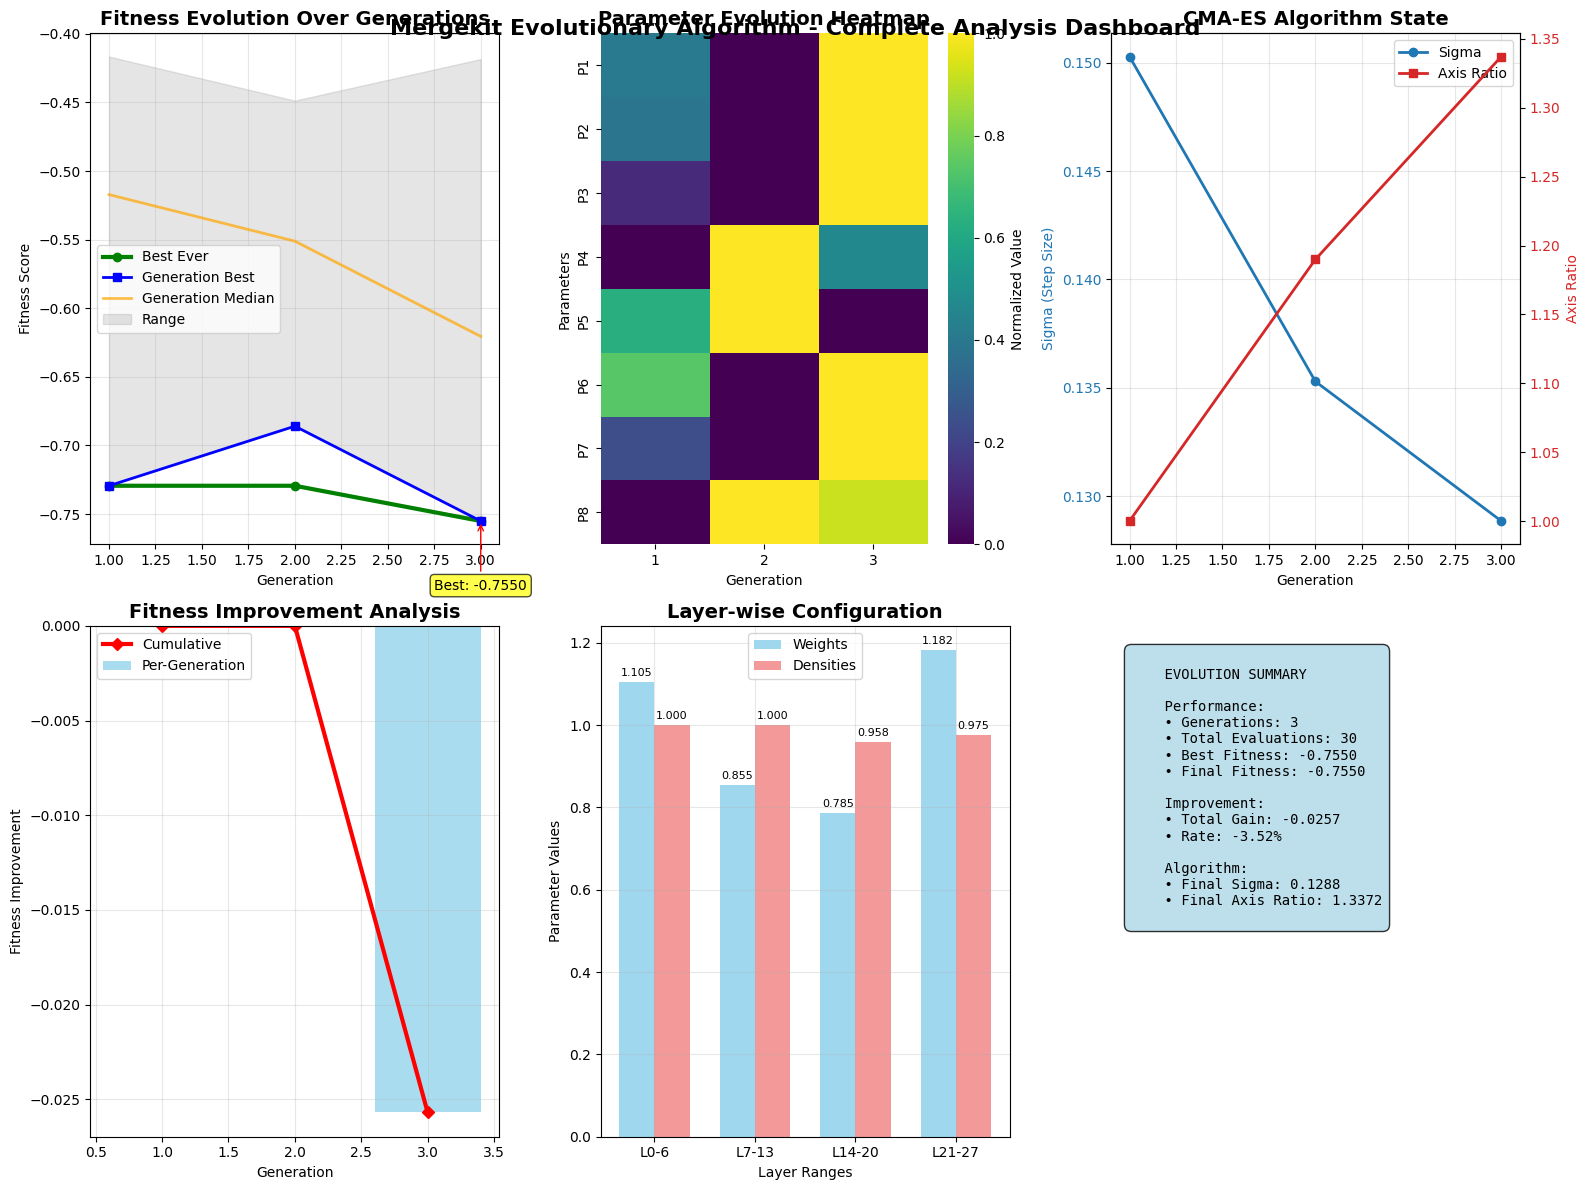

✅ Evolution analysis complete!


In [16]:
import matplotlib.pyplot as plt
# Create comprehensive visualization of evolution progress
plt.figure(figsize=(16, 12))

# Determine if we have multi-generation data
is_multi_gen = len(fitness_df) > 1 if not fitness_df.empty else False
print(f"📊 Creating visualizations for {'multi-generation' if is_multi_gen else 'single-generation'} data...")

# 1. Fitness Evolution Over Time
plt.subplot(2, 3, 1)
if not fitness_df.empty:
    if is_multi_gen:
        plt.plot(fitness_df['iteration'], fitness_df['best_ever'], 'g-', linewidth=3, label='Best Ever', marker='o')
        plt.plot(fitness_df['iteration'], fitness_df['best'], 'b-', linewidth=2, label='Generation Best', marker='s')
        plt.plot(fitness_df['iteration'], fitness_df['median'], 'orange', linewidth=2, label='Generation Median', alpha=0.7)
        plt.fill_between(fitness_df['iteration'], fitness_df['best'], fitness_df['worst'], alpha=0.2, color='gray', label='Range')

        # Annotate best point
        best_idx = fitness_df['best_ever'].idxmin()
        best_gen = fitness_df.loc[best_idx, 'iteration']
        best_score = fitness_df.loc[best_idx, 'best_ever']
        plt.annotate(f'Best: {best_score:.4f}',
                    xy=(best_gen, best_score),
                    xytext=(best_gen, best_score-0.05),
                    arrowprops=dict(arrowstyle='->', color='red'),
                    fontsize=10, ha='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    else:
        # Single generation - show as points with comparison
        gen = fitness_df['iteration'].iloc[0]
        best_ever = fitness_df['best_ever'].iloc[0]
        best = fitness_df['best'].iloc[0]
        median = fitness_df['median'].iloc[0]
        worst = fitness_df['worst'].iloc[0]

        plt.scatter([gen], [best_ever], s=150, color='green', label='Best Ever', marker='o', zorder=5)
        plt.scatter([gen], [best], s=120, color='blue', label='Generation Best', marker='s', zorder=4)
        plt.scatter([gen], [median], s=100, color='orange', label='Median', marker='^', zorder=3)
        plt.scatter([gen], [worst], s=80, color='red', label='Worst', marker='v', zorder=2)

        # Add range line
        plt.plot([gen, gen], [worst, best_ever], 'k-', alpha=0.5, linewidth=2, label='Population Range')

        # Annotate values
        plt.annotate(f'Best: {best_ever:.4f}', xy=(gen, best_ever), xytext=(gen+0.1, best_ever),
                    fontsize=9, ha='left', bbox=dict(boxstyle="round,pad=0.2", facecolor="lightgreen", alpha=0.7))

    plt.title('Fitness Evolution Over Generations', fontsize=14, fontweight='bold')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 2. Parameter Evolution/Distribution
plt.subplot(2, 3, 2)
if not param_df.empty:
    param_cols = [col for col in param_df.columns if col.startswith('param_')]
    if param_cols:
        if is_multi_gen:
            # Multi-generation heatmap
            param_matrix = param_df[param_cols].values.T
            param_matrix_norm = np.zeros_like(param_matrix)
            for i in range(param_matrix.shape[0]):
                if param_matrix[i].max() != param_matrix[i].min():
                    param_matrix_norm[i] = (param_matrix[i] - param_matrix[i].min()) / (param_matrix[i].max() - param_matrix[i].min())
                else:
                    param_matrix_norm[i] = param_matrix[i]

            sns.heatmap(param_matrix_norm,
                       xticklabels=param_df['iteration'].values,
                       yticklabels=[f'P{i+1}' for i in range(len(param_cols))],
                       cmap='viridis', cbar_kws={'label': 'Normalized Value'})
            plt.title('Parameter Evolution Heatmap', fontsize=14, fontweight='bold')
            plt.xlabel('Generation')
        else:
            # Single generation - bar chart
            param_values = [param_df[param].iloc[0] for param in param_cols]
            param_names = [f'P{i+1}' for i in range(len(param_values))]
            colors = plt.cm.Set3(np.linspace(0, 1, len(param_values)))

            bars = plt.bar(param_names, param_values, color=colors, alpha=0.8)

            # Add value labels
            for bar, value in zip(bars, param_values):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.3f}', ha='center', va='bottom', fontsize=9)

            plt.title('Parameter Values', fontsize=14, fontweight='bold')
            plt.xlabel('Parameters')

        plt.ylabel('Value' if not is_multi_gen else 'Parameters')

# 3. Algorithm State Evolution
plt.subplot(2, 3, 3)
if not fitness_df.empty:
    if is_multi_gen:
        ax1 = plt.gca()
        color = 'tab:blue'
        ax1.set_xlabel('Generation')
        ax1.set_ylabel('Sigma (Step Size)', color=color)
        line1 = ax1.plot(fitness_df['iteration'], fitness_df['sigma'], color=color, linewidth=2, marker='o')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True, alpha=0.3)

        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Axis Ratio', color=color)
        line2 = ax2.plot(fitness_df['iteration'], fitness_df['axis_ratio'], color=color, linewidth=2, marker='s')
        ax2.tick_params(axis='y', labelcolor=color)

        lines = line1 + line2
        labels = ['Sigma', 'Axis Ratio']
        ax1.legend(lines, labels, loc='upper right')
    else:
        # Single generation - bar chart of algorithm state
        metrics = {
            'Sigma': fitness_df['sigma'].iloc[0],
            'Axis Ratio': fitness_df['axis_ratio'].iloc[0],
            'IQR': fitness_df['iqr'].iloc[0]
        }

        bars = plt.bar(metrics.keys(), metrics.values(), color=['blue', 'red', 'green'], alpha=0.7)

        # Add value labels
        for bar, (key, value) in zip(bars, metrics.items()):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{value:.4f}', ha='center', va='bottom', fontsize=9)

        plt.ylabel('Value')

    plt.title('CMA-ES Algorithm State', fontsize=14, fontweight='bold')

# 4. Performance Analysis
plt.subplot(2, 3, 4)
if not fitness_df.empty:
    if is_multi_gen:
        # Multi-generation improvement analysis
        improvements = fitness_df['best_ever'].diff().fillna(0)
        cumulative_improvement = (fitness_df['best_ever'] - fitness_df['best_ever'].iloc[0])

        plt.bar(fitness_df['iteration'], improvements, alpha=0.7, color='skyblue', label='Per-Generation')
        plt.plot(fitness_df['iteration'], cumulative_improvement, 'r-', linewidth=3, label='Cumulative', marker='D')

        plt.title('Fitness Improvement Analysis', fontsize=14, fontweight='bold')
        plt.xlabel('Generation')
        plt.ylabel('Fitness Improvement')
        plt.legend()
    else:
        # Single generation - population distribution
        values = [
            fitness_df['best_ever'].iloc[0],
            fitness_df['best'].iloc[0],
            fitness_df['median'].iloc[0],
            fitness_df['worst'].iloc[0]
        ]
        labels = ['Best Ever', 'Best', 'Median', 'Worst']
        colors = ['green', 'blue', 'orange', 'red']

        bars = plt.bar(labels, values, color=colors, alpha=0.7)

        # Add value labels
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=9)

        plt.title('Population Fitness Distribution', fontsize=14, fontweight='bold')
        plt.ylabel('Fitness Score')
        plt.xticks(rotation=45)

    plt.grid(True, alpha=0.3)

# 5. Best Configuration Visualization
plt.subplot(2, 3, 5)
try:
    with open(storage_path / 'best_config.yaml', 'r') as f:
        best_config = yaml.safe_load(f)

    if 'slices' in best_config:
        # Extract weights and densities
        weights = []
        densities = []
        layer_labels = []

        for i, slice_config in enumerate(best_config['slices']):
            if 'sources' in slice_config:
                for source in slice_config['sources']:
                    if 'parameters' in source and 'layer_range' in source:
                        layer_range = source['layer_range']
                        weight = source['parameters'].get('weight', 1.0)
                        density = source['parameters'].get('density', 1.0)

                        if layer_range[0] != layer_range[1]-1:  # Skip if single layer
                            weights.append(weight)
                            densities.append(density)
                            layer_labels.append(f"L{layer_range[0]}-{layer_range[1]-1}")

        if weights and densities:
            x = np.arange(len(layer_labels))
            width = 0.35

            bars1 = plt.bar(x - width/2, weights, width, label='Weights', alpha=0.8, color='skyblue')
            bars2 = plt.bar(x + width/2, densities, width, label='Densities', alpha=0.8, color='lightcoral')

            # Add value labels
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{height:.3f}', ha='center', va='bottom', fontsize=8)

            plt.xlabel('Layer Ranges')
            plt.ylabel('Parameter Values')
            plt.title('Layer-wise Configuration', fontsize=14, fontweight='bold')
            plt.xticks(x, layer_labels)
            plt.legend()
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'No layer parameters\nfound', ha='center', va='center',
                    transform=plt.gca().transAxes, fontsize=12)
            plt.title('Configuration Analysis', fontsize=14, fontweight='bold')

except Exception as e:
    plt.text(0.5, 0.5, f'Config Error:\n{str(e)[:50]}...', ha='center', va='center',
            transform=plt.gca().transAxes, fontsize=10)
    plt.title('Configuration Analysis', fontsize=14, fontweight='bold')

# 6. Summary Statistics
plt.subplot(2, 3, 6)
plt.axis('off')
if not fitness_df.empty:
    if is_multi_gen:
        stats_text = f"""
    EVOLUTION SUMMARY

    Performance:
    • Generations: {len(fitness_df)}
    • Total Evaluations: {fitness_df['evaluation'].max()}
    • Best Fitness: {fitness_df['best_ever'].min():.4f}
    • Final Fitness: {fitness_df['best'].iloc[-1]:.4f}

    Improvement:
    • Total Gain: {(fitness_df['best'].iloc[-1] - fitness_df['best'].iloc[0]):.4f}
    • Rate: {((fitness_df['best'].iloc[-1] - fitness_df['best'].iloc[0]) / abs(fitness_df['best'].iloc[0]) * 100):.2f}%

    Algorithm:
    • Final Sigma: {fitness_df['sigma'].iloc[-1]:.4f}
    • Final Axis Ratio: {fitness_df['axis_ratio'].iloc[-1]:.4f}
    """
    else:
        stats_text = f"""
    SINGLE RUN SUMMARY

    Performance:
    • Generation: {fitness_df['iteration'].iloc[0]}
    • Evaluations: {fitness_df['evaluation'].iloc[0]}
    • Best Fitness: {fitness_df['best_ever'].iloc[0]:.4f}
    • Population Range: {fitness_df['worst'].iloc[0]:.4f} to {fitness_df['best'].iloc[0]:.4f}

    Algorithm State:
    • Sigma: {fitness_df['sigma'].iloc[0]:.4f}
    • Axis Ratio: {fitness_df['axis_ratio'].iloc[0]:.4f}
    • IQR: {fitness_df['iqr'].iloc[0]:.4f}

    Status: Quick Evolution Run
    Note: Single generation indicates
    rapid optimization or early stopping
    """

    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

plt.tight_layout()
plt.suptitle('Mergekit Evolutionary Algorithm - Complete Analysis Dashboard',
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

print("✅ Evolution analysis complete!")


## 🧪 Evaluate Best Models

Let's create and test the best evolved model to see the performance improvements.

## 💾 Export Final Models

Let's package and prepare the results for download and future use.